In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_percentage_error, r2_score


In [2]:
!curl -O https://lazyprogrammer.me/course_files/timeseries/perrin-freres-monthly-champagne.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  1598  100  1598    0     0   5805      0 --:--:-- --:--:-- --:--:--  5832


In [6]:
df = pd.read_csv('perrin-freres-monthly-champagne.csv',
                 index_col='Month',
                 skipfooter=2,
                 parse_dates=True)

C:\Users\zheng\AppData\Local\Temp\ipykernel_7900\4068704467.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('perrin-freres-monthly-champagne.csv',


In [7]:
df.columns = ['Sales']
df.head()

,Sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


In [8]:
df['LogSales'] = np.log(df['Sales'])
Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [9]:
series = df['LogSales'].to_numpy()
# Single-step forecast
T = 12
X = [series[t:t+T] for t in range(len(series) - T)]
Y = [series[t+T] for t in range(len(series) - T)]
X = np.array(X).reshape(-1, T)
Y = np.array(Y)
X.shape, Y.shape

((93, 12), (93,))

In [10]:
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

In [11]:
lr = LinearRegression()
lr.fit(Xtrain, Ytrain)
lr.score(Xtrain, Ytrain)

0.8682372095558998

In [12]:
lr.score(Xtest, Ytest)

0.9657520752272786

In [13]:
train_idx = df.index <= train.index[-1]
test_idx = ~train_idx
train_idx[:T] = False

In [17]:
df.loc[train_idx, 'LR_1step_train'] = lr.predict(Xtrain)
df.loc[test_idx, 'LR_1step_test'] = lr.predict(Xtest)

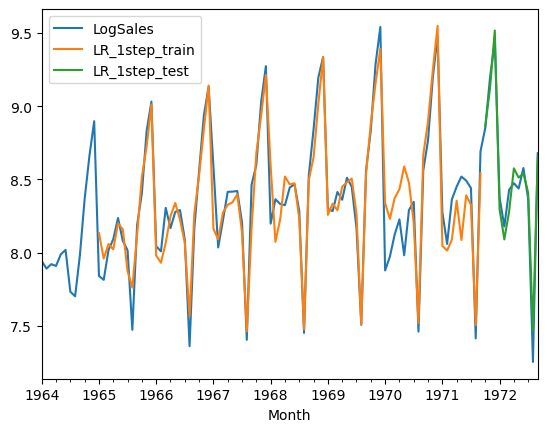

In [18]:
cols = ['LogSales', 'LR_1step_train', 'LR_1step_test']
df[cols].plot();

In [19]:
# Multi-step forecast
multistep_preds = []
last_x = Xtest[0]

while len(multistep_preds) < Ntest:
    p = lr.predict(last_x.reshape(1, -1))[0]
    multistep_preds.append(p)
    
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

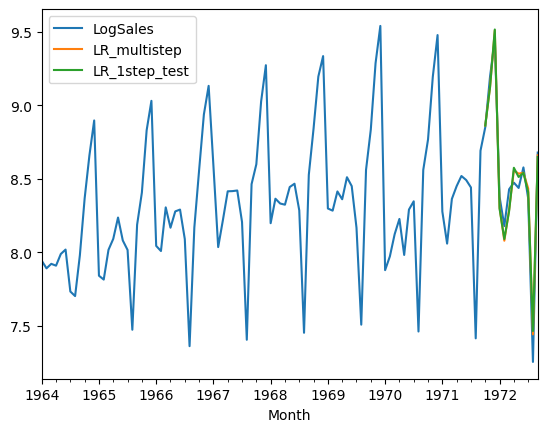

In [21]:
df.loc[test_idx, 'LR_multistep'] = multistep_preds
cols = ['LogSales', 'LR_multistep', 'LR_1step_test']
df[cols].plot();

Make multi-output dataset

In [22]:
Tx = T
Ty = Ntest
X = [series[t:t+Tx] for t in range(len(series) - Tx - Ty + 1)]
Y = [series[t+Tx:t+Tx+Ty] for t in range(len(series) - Tx - Ty + 1)]
X = np.array(X).reshape(-1, Tx)
Y = np.array(Y).reshape(-1, Ty)
X.shape, Y.shape

((82, 12), (82, 12))

In [33]:
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

In [34]:
lr = LinearRegression()
lr.fit(Xtrain_m, Ytrain_m)
lr.score(Xtrain_m, Ytrain_m)

0.8829262390390559

In [35]:
r2_score(lr.predict(Xtest_m).flatten(), Ytest_m.flatten())

0.9595107879158427

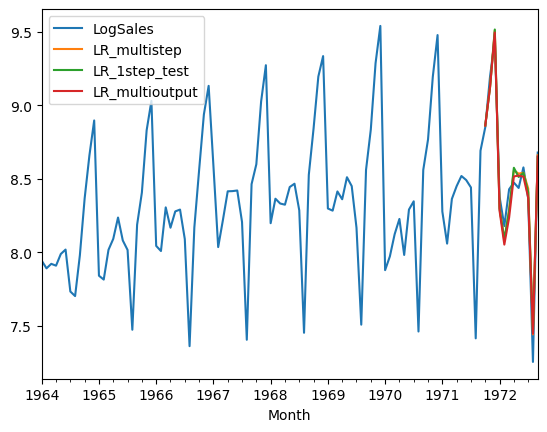

In [36]:
df.loc[test_idx, 'LR_multioutput'] = lr.predict(Xtest_m).flatten()
cols = ['LogSales', 'LR_multistep', 'LR_1step_test', 'LR_multioutput']
df[cols].plot();

In [38]:
# MAPE
mape1 = mean_absolute_percentage_error(Ytest, multistep_preds)
print("multi-step MAPE:", mape1)
mape2 = mean_absolute_percentage_error(
    Ytest, df.loc[test_idx, 'LR_multioutput'])
print("multi-output MAPE:", mape2)

multi-step MAPE: 0.009607169373797688
multi-output MAPE: 0.009727020853255875


In [39]:
def one_step_and_multistep_forecast(model, name):
    model.fit(Xtrain, Ytrain)
    print("One-step forecast:", name)
    # print("Train R^2:", model.score(Xtrain, Ytrain))
    # print("Test R^2 (1-step):", model.score(Xtest, Ytest))

    # store 1-step forecast
    df.loc[train_idx, f'{name}_1step_train'] = model.predict(Xtrain)
    df.loc[test_idx, f'{name}_1step_test'] = model.predict(Xtest)

    # generate multi-step forecast
    multistep_predictions = []

    # first test input
    last_x = Xtest[0]

    while len(multistep_predictions) < Ntest:
        p = model.predict(last_x.reshape(1, -1))[0]

        # update the predictions list
        multistep_predictions.append(p)

        # make the new input
        last_x = np.roll(last_x, -1)
        last_x[-1] = p

    # store multi-step forecast
    df.loc[test_idx, f'{name}_multistep_test'] = multistep_predictions

    # MAPE of multi-step forecast
    mape = mean_absolute_percentage_error(Ytest, multistep_predictions)
    print("Test MAPE (multi-step):", mape)

    # plot 1-step and multi-step forecast
    cols = [
        'LogSales',
        f'{name}_1step_train',
        f'{name}_1step_test',
        f'{name}_multistep_test'
    ]
    df[cols].plot();

One-step forecast: SVR
Test MAPE (multi-step): 0.013188370472848127


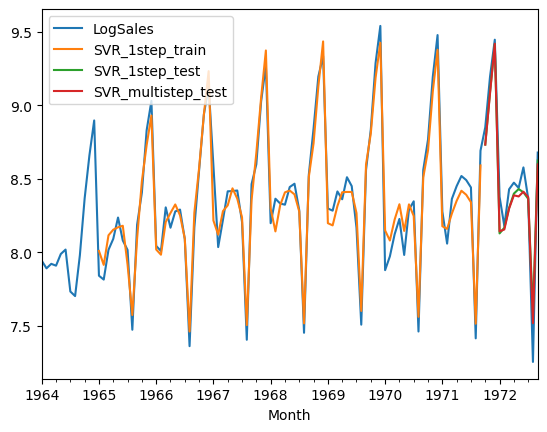

In [40]:
one_step_and_multistep_forecast(SVR(), "SVR")

One-step forecast: RF
Test MAPE (multi-step): 0.011440540641501558


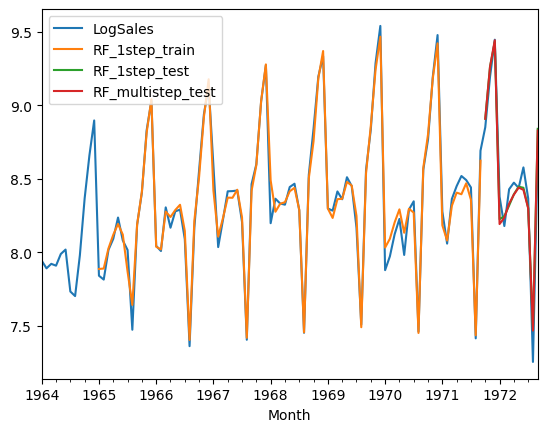

In [41]:
one_step_and_multistep_forecast(RandomForestRegressor(), "RF")

In [42]:
def multi_output_forecast(model, name):
    model.fit(Xtrain_m, Ytrain_m)

    # save multi-output forecast to dataframe
    df.loc[test_idx, f'{name}_multioutput'] = model.predict(Xtest_m).flatten()

    mape = mean_absolute_percentage_error(
        Ytest, df.loc[test_idx, f'{name}_multioutput'])
    print("Test MAPE (multi-output):", mape)

    # plot all forecasts
    # assume that previous functions have been run
    cols = [
        'LogSales',
        f'{name}_1step_train',
        f'{name}_1step_test',
        f'{name}_multistep_test',
        f'{name}_multioutput',
    ]
    df[cols].plot();

Test MAPE (multi-output): 0.018843772992580016


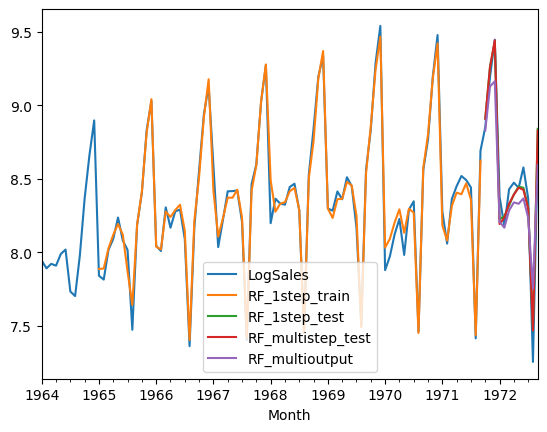

In [43]:
multi_output_forecast(RandomForestRegressor(), "RF")

Try differencing the data

In [44]:
df['DiffLogSales'] = df['LogSales'].diff()
series = df['DiffLogSales'].to_numpy()[1:]
T = 10
X = [series[t:t+T] for t in range(len(series) - T)]
Y = [series[t+T] for t in range(len(series) - T)]

X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N = len(X)
X.shape, Y.shape

((94, 10), (94,))

In [45]:
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

In [46]:
lr = LinearRegression()
lr.fit(Xtrain, Ytrain)
lr.score(Xtrain, Ytrain)

0.6848723712202343

In [47]:
lr.score(Xtest, Ytest)

0.6475727599556207

In [48]:
train_idx = df.index <= train.index[-1]
test_idx = ~train_idx

# You can't predict first T values
train_idx[:T+1] = False

In [49]:
# Needed to compute un-differenced predictions
df['ShiftLogSales'] = df['LogSales'].shift(1)
prev = df['ShiftLogSales']

# Last-known train value
last_train = train.iloc[-1]['LogSales']

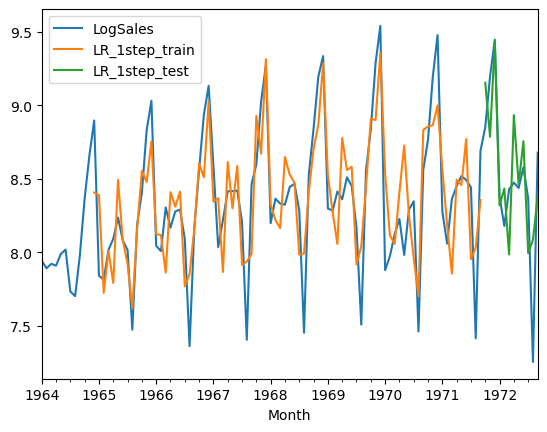

In [52]:
df.loc[train_idx, 'LR_1step_train'] = prev[train_idx] + lr.predict(Xtrain)
df.loc[test_idx, 'LR_1step_test'] = prev[test_idx] + lr.predict(Xtest)

# plot 1-step forecast
df[['LogSales', 'LR_1step_train', 'LR_1step_test']].plot();

In [53]:
# Perform multi-step forecasting
multistep_preds = []

# First test input
last_x = Xtest[0]

while len(multistep_preds) < Ntest:
    p = lr.predict(last_x.reshape(1, -1))[0]
    multistep_preds.append(p)
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

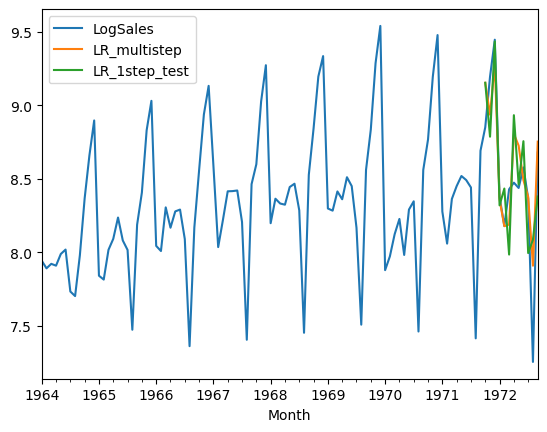

In [54]:
# save multi-step forecast to dataframe
df.loc[test_idx, 'LR_multistep'] = last_train + np.cumsum(multistep_preds)
df[['LogSales', 'LR_multistep', 'LR_1step_test']].plot();

In [55]:
Tx, Ty = T, Ntest
X = [series[t:t+Tx] for t in range(len(series) - Tx - Ty + 1)]
Y = [series[t+Tx:t+Tx+Ty] for t in range(len(series) - Tx - Ty + 1)]

X = np.array(X).reshape(-1, Tx)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (83, 10) Y.shape (83, 12)


In [56]:
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

In [57]:
lr = LinearRegression()
lr.fit(Xtrain_m, Ytrain_m)
lr.score(Xtrain_m, Ytrain_m)

0.8130430536569305

In [58]:
r2_score(lr.predict(Xtest_m).flatten(), Ytest_m.flatten())

0.9114875250243071